In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import time

In [ ]:
#For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Dataset Selection and Preprocessing
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split the training set to create a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

#Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# Data normalization
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, len(class_names))
y_val = tf.keras.utils.to_categorical(y_val, len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, len(class_names))


In [5]:
# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [6]:
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


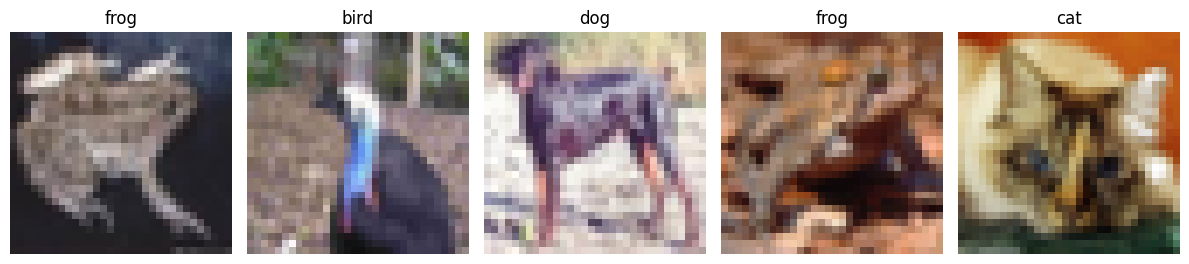

In [ ]:
#Visualize some sample images
def display_sample_images(X, y, class_names, num_samples=5):
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[i])
        plt.title(class_names[np.argmax(y[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a few training samples
display_sample_images(x_train, y_train, class_names)

In [ ]:
#Single-Model Development
def create_resnet_model():
    """Create a ResNet50 model with transfer learning"""
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        # Preprocessing: ResNet expects inputs in a specific range
        layers.Lambda(lambda x: tf.keras.applications.resnet.preprocess_input(x * 255.0)),
        
        # Base model
        base_model,
        
        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [21]:
def create_vgg_model():
    """Create a VGG16 model with transfer learning"""
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        # Preprocessing: VGG expects inputs in a specific range
        layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x * 255.0)),
        
        # Base model
        base_model,
        
        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [20]:
def create_densenet_model():
    """Create a DenseNet121 model with transfer learning"""
    base_model = applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        # Preprocessing: DenseNet expects inputs in a specific range
        layers.Lambda(lambda x: tf.keras.applications.densenet.preprocess_input(x * 255.0)),
        
        # Base model
        base_model,
        
        # Classification head
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [11]:
# Create callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


In [ ]:
#Train the models or load pre-trained weights
def train_or_load_model(model_fn, model_name, epochs=30, batch_size=64):
    model_path = f'{model_name}_cifar10.weights.h5'
    
    if os.path.exists(model_path):
        print(f"Loading pre-trained {model_name} model...")
        model = model_fn()
        model.load_weights(model_path)
    else:
        print(f"Training {model_name} model from scratch...")
        model = model_fn()
        
        # Training with data augmentation
        history = model.fit(
            data_augmentation.flow(x_train, y_train, batch_size=batch_size),
            validation_data=(x_val, y_val),
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Training Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.tight_layout()
        plt.show()
        
        # Save the model weights
        model.save_weights(model_path)
    
    return model

Training resnet model from scratch...
Epoch 1/5


c:\Users\GenAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 278ms/step - accuracy: 0.4221 - loss: 2.0237 - val_accuracy: 0.6051 - val_loss: 1.1273 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 271ms/step - accuracy: 0.5331 - loss: 1.3451 - val_accuracy: 0.6390 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 166s 266ms/step - accuracy: 0.5591 - loss: 1.2729 - val_accuracy: 0.6424 - val_loss: 1.0314 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 308ms/step - accuracy: 0.5706 - loss: 1.2251 - val_accuracy: 0.6514 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 294ms/step - accuracy: 0.5822 - loss: 1.1933 - val_accuracy: 0.6515 - val_loss: 0.9976 - learning_rate: 0.0010


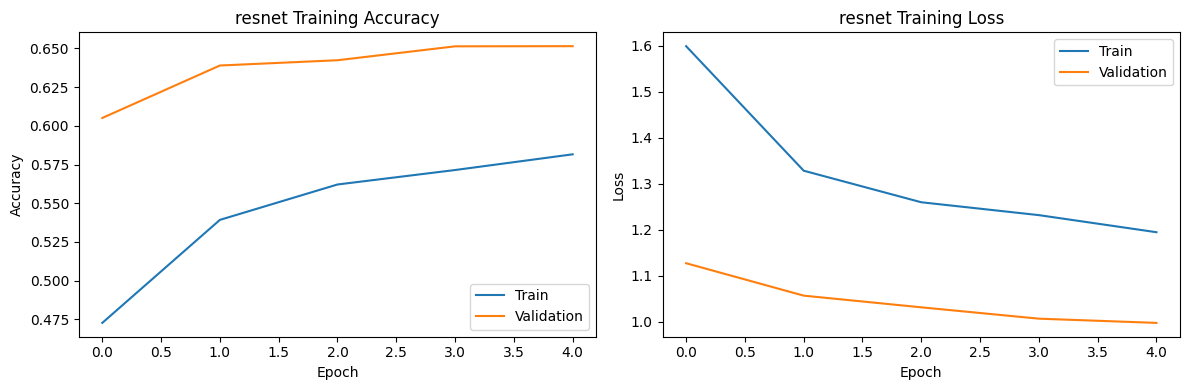

In [19]:
# Train or load models
resnet_model = train_or_load_model(create_resnet_model, 'resnet', epochs=5)

Training vgg model from scratch...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 368ms/step - accuracy: 0.3665 - loss: 4.5851 - val_accuracy: 0.5695 - val_loss: 1.2335 - learning_rate: 0.0020
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - accuracy: 0.4869 - loss: 1.4926 - val_accuracy: 0.5920 - val_loss: 1.1666 - learning_rate: 0.0020
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 243s 389ms/step - accuracy: 0.5164 - loss: 1.4064 - val_accuracy: 0.6201 - val_loss: 1.1069 - learning_rate: 0.0020
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 415ms/step - accuracy: 0.5314 - loss: 1.3734 - val_accuracy: 0.6258 - val_loss: 1.1013 - learning_rate: 0.0020
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 246s 393ms/step - accuracy: 0.5371 - loss: 1.3667 - val_accuracy: 0.6261 - val_loss: 1.1132 - learning_rate: 0.0020


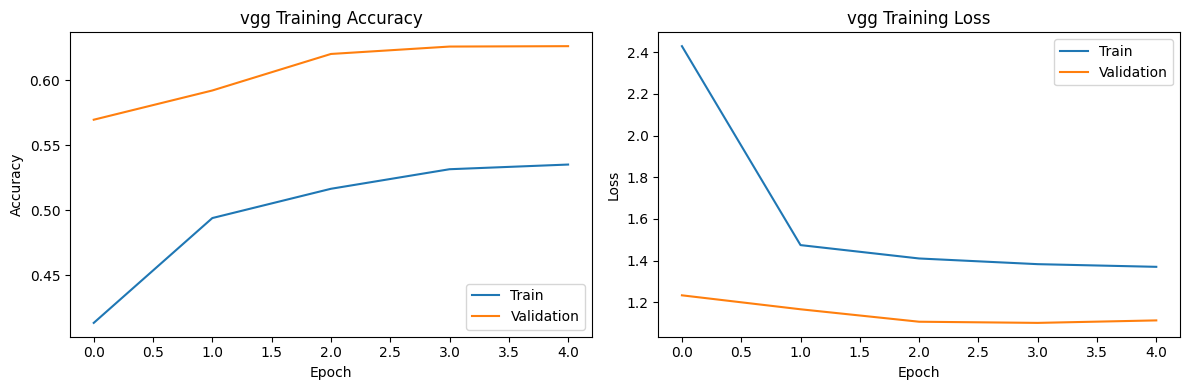

In [22]:
vgg_model = train_or_load_model(create_vgg_model, 'vgg', epochs=5)

Training densenet model from scratch...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 173ms/step - accuracy: 0.4438 - loss: 1.6772 - val_accuracy: 0.6179 - val_loss: 1.0628 - learning_rate: 0.0020
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.5552 - loss: 1.2726 - val_accuracy: 0.6339 - val_loss: 1.0284 - learning_rate: 0.0020
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.5730 - loss: 1.2157 - val_accuracy: 0.6490 - val_loss: 0.9840 - learning_rate: 0.0020
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 166ms/step - accuracy: 0.5714 - loss: 1.2050 - val_accuracy: 0.6630 - val_loss: 0.9660 - learning_rate: 0.0020
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 159ms/step - accuracy: 0.5859 - loss: 1.1860 - val_accuracy: 0.6682 - val_loss: 0.9503 - learning_rate: 0.0020


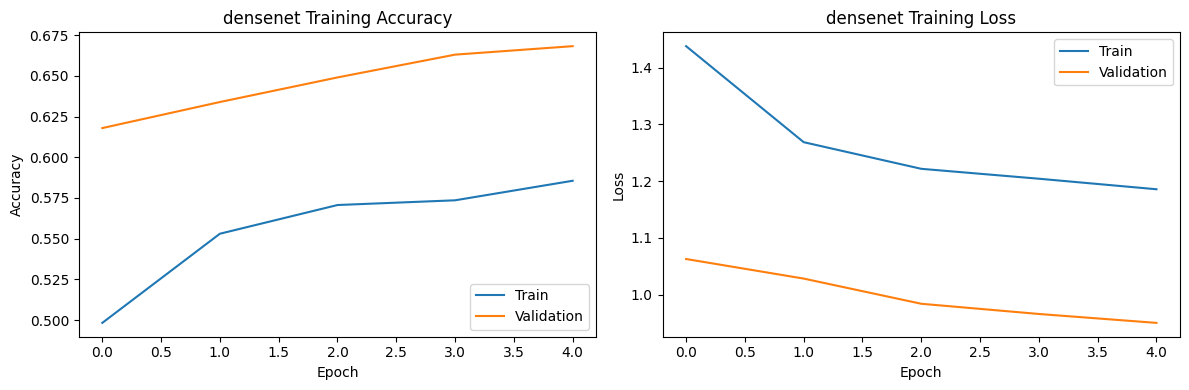

In [23]:
densenet_model = train_or_load_model(create_densenet_model, 'densenet', epochs=5)

In [24]:
#Model Fusion Techniques
# Late Fusion (Average Ensemble)
def late_fusion_model(models, x_input):
    # Get predictions from all models
    predictions = []
    for model in models:
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred)
    
    # Average the predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred


In [ ]:
#Stacking (Meta-Learning)
def create_stacking_model(base_models, meta_input_shape):
    """Create a meta-learner model for stacking"""
    inputs = tf.keras.Input(shape=meta_input_shape)
    
    # Dense layers for meta-learning
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    meta_model = models.Model(inputs=inputs, outputs=outputs)
    meta_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return meta_model

In [26]:
def prepare_meta_features(base_models, x_input):
    """Generate features for the meta-learner by getting predictions from base models"""
    meta_features = []
    for model in base_models:
        preds = model.predict(x_input, verbose=0)
        meta_features.append(preds)
    
    # Concatenate predictions from all models
    return np.concatenate(meta_features, axis=1)


In [27]:
# Generate meta-features for training and validation
base_models = [resnet_model, vgg_model, densenet_model]
meta_features_train = prepare_meta_features(base_models, x_train)
meta_features_val = prepare_meta_features(base_models, x_val)
meta_features_test = prepare_meta_features(base_models, x_test)

In [28]:
# Create and train the stacking model
print("\nTraining stacking model...")
stacking_model = create_stacking_model(base_models, meta_features_train.shape[1:])
stacking_history = stacking_model.fit(
    meta_features_train, y_train,
    validation_data=(meta_features_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Training stacking model...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5932 - loss: 1.3589 - val_accuracy: 0.7186 - val_loss: 0.8513 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7206 - loss: 0.8429 - val_accuracy: 0.7181 - val_loss: 0.8414 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7297 - loss: 0.8223 - val_accuracy: 0.7185 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7277 - loss: 0.8131 - val_accuracy: 0.7188 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7276 - loss: 0.8081 - val_accuracy: 0.7200 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7310 - loss: 0.8012 - val_accuracy: 0.7218 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accura

In [ ]:
#Evaluation and Analysis

def evaluate_model(model, x_test, y_test, name="Model"):
    """Evaluate a single model and return metrics"""
    start_time = time.time()
    y_pred_probs = model.predict(x_test, verbose=0)
    inference_time = time.time() - start_time
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.2f} seconds")
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'inference_time': inference_time,
        'y_pred': y_pred,
        'y_true': y_true
    }


ResNet50 Performance:
Accuracy: 0.6455
Precision: 0.6485
Recall: 0.6455
F1 Score: 0.6419
Inference Time: 48.57 seconds


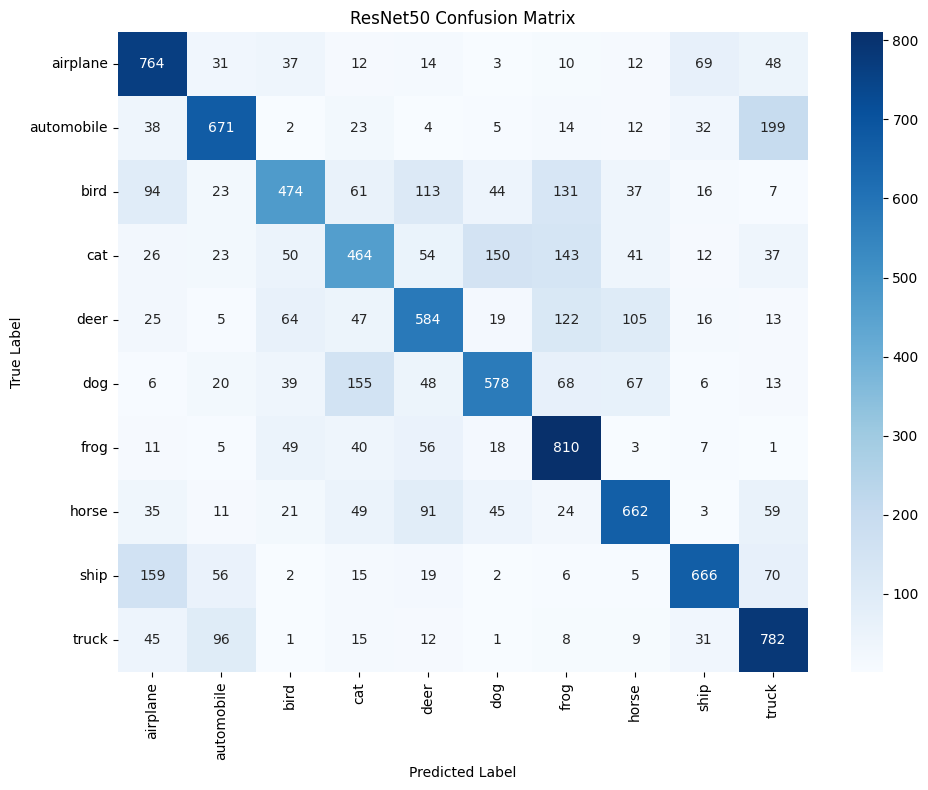


VGG16 Performance:
Accuracy: 0.6284
Precision: 0.6261
Recall: 0.6284
F1 Score: 0.6226
Inference Time: 48.13 seconds


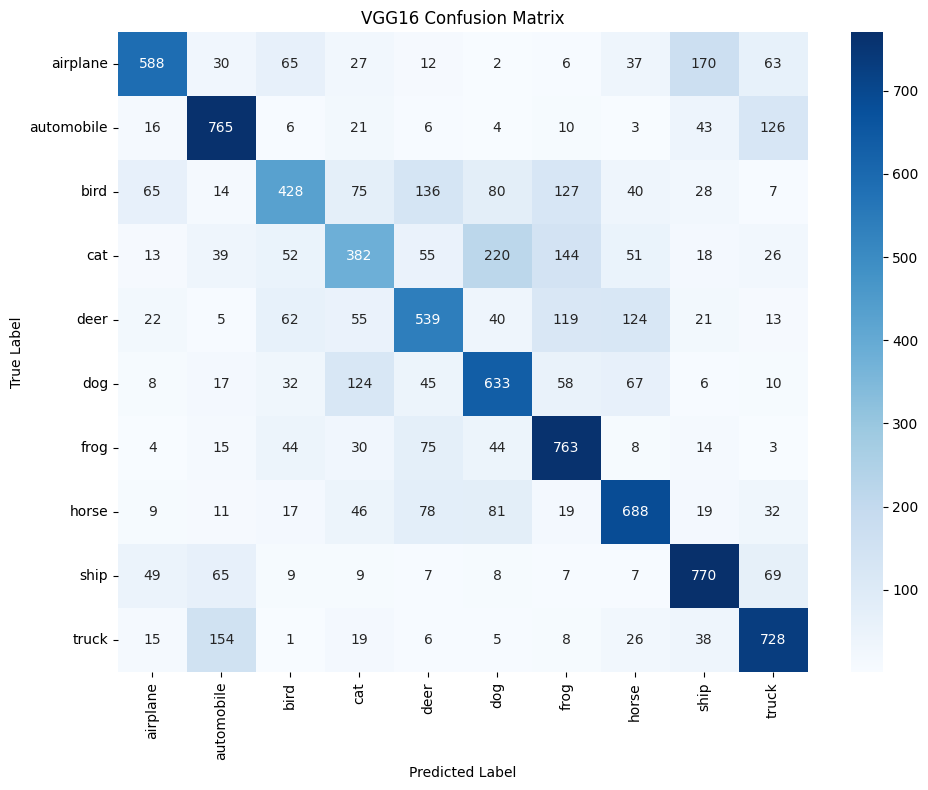


DenseNet121 Performance:
Accuracy: 0.6615
Precision: 0.6645
Recall: 0.6615
F1 Score: 0.6598
Inference Time: 24.10 seconds


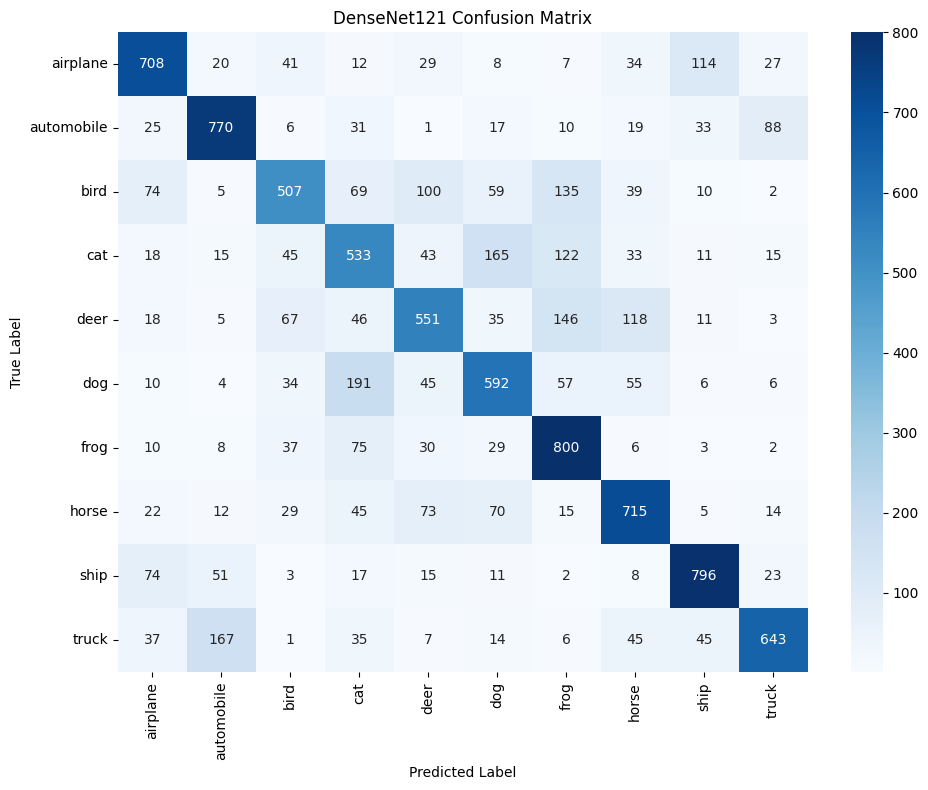

In [30]:
# Evaluate individual models
resnet_metrics = evaluate_model(resnet_model, x_test, y_test, "ResNet50")
vgg_metrics = evaluate_model(vgg_model, x_test, y_test, "VGG16")
densenet_metrics = evaluate_model(densenet_model, x_test, y_test, "DenseNet121")


In [ ]:
# Evaluate late fusion (average ensemble)
late_fusion_preds = late_fusion_model([resnet_model, vgg_model, densenet_model], x_test)
late_fusion_metrics = {
    'y_pred': np.argmax(late_fusion_preds, axis=1),
    'y_true': np.argmax(y_test, axis=1)
}


In [32]:
# Calculate metrics for late fusion
late_fusion_metrics['accuracy'] = accuracy_score(late_fusion_metrics['y_true'], late_fusion_metrics['y_pred'])
late_fusion_metrics['precision'] = precision_score(late_fusion_metrics['y_true'], late_fusion_metrics['y_pred'], average='weighted')
late_fusion_metrics['recall'] = recall_score(late_fusion_metrics['y_true'], late_fusion_metrics['y_pred'], average='weighted')
late_fusion_metrics['f1'] = f1_score(late_fusion_metrics['y_true'], late_fusion_metrics['y_pred'], average='weighted')

print("Late Fusion Performance:")
print(f"Accuracy: {late_fusion_metrics['accuracy']:.4f}")
print(f"Precision: {late_fusion_metrics['precision']:.4f}")
print(f"Recall: {late_fusion_metrics['recall']:.4f}")
print(f"F1 Score: {late_fusion_metrics['f1']:.4f}")


Late Fusion Performance:
Accuracy: 0.7091
Precision: 0.7088
Recall: 0.7091
F1 Score: 0.7056


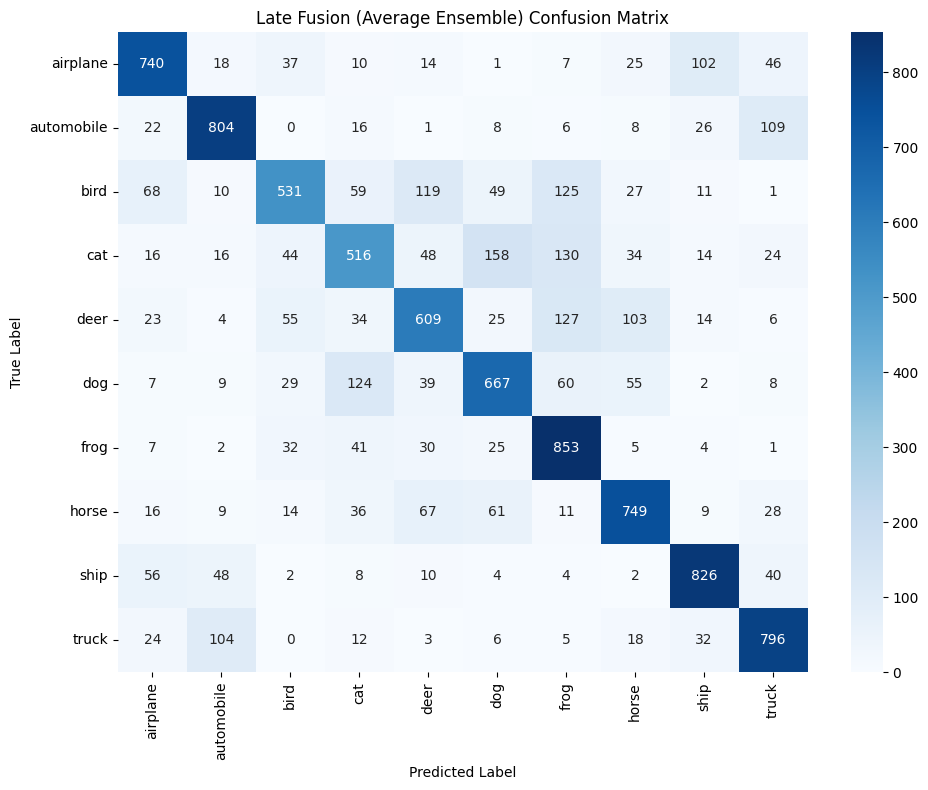

In [33]:
# Plot confusion matrix for late fusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(late_fusion_metrics['y_true'], late_fusion_metrics['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Late Fusion (Average Ensemble) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


Evaluating Stacking Model...
Stacking Model Performance:
Accuracy: 0.7153
Precision: 0.7142
Recall: 0.7153
F1 Score: 0.7140


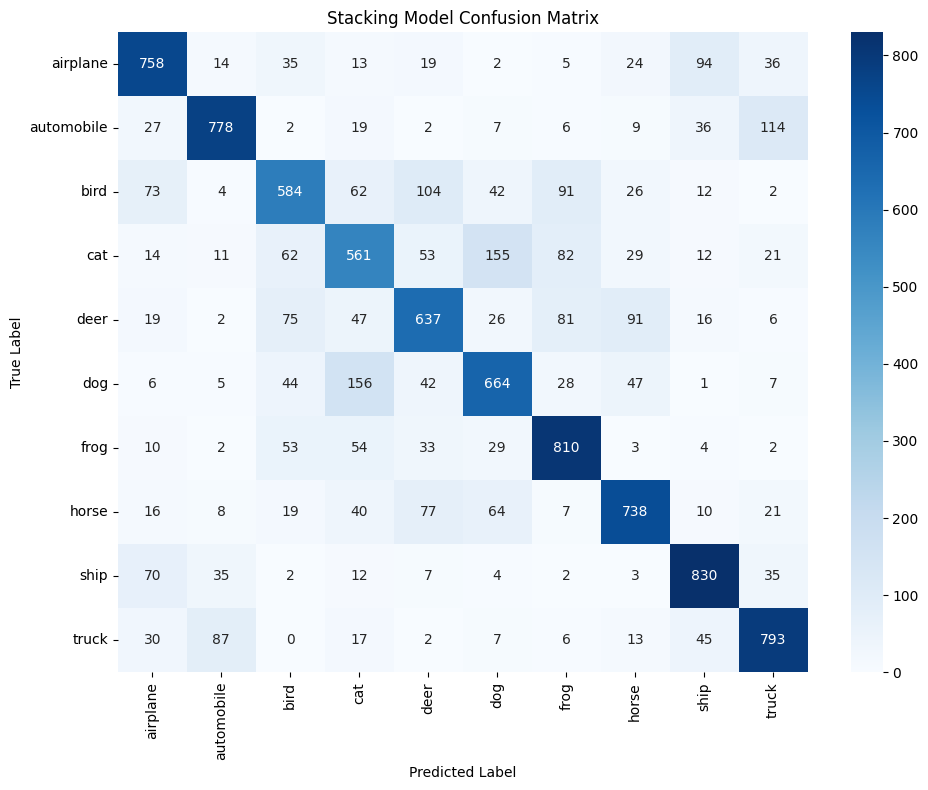

In [34]:
# Evaluate stacking model
print("\nEvaluating Stacking Model...")
stacking_pred_probs = stacking_model.predict(meta_features_test, verbose=0)
stacking_metrics = {
    'y_pred': np.argmax(stacking_pred_probs, axis=1),
    'y_true': np.argmax(y_test, axis=1)
}

stacking_metrics['accuracy'] = accuracy_score(stacking_metrics['y_true'], stacking_metrics['y_pred'])
stacking_metrics['precision'] = precision_score(stacking_metrics['y_true'], stacking_metrics['y_pred'], average='weighted')
stacking_metrics['recall'] = recall_score(stacking_metrics['y_true'], stacking_metrics['y_pred'], average='weighted')
stacking_metrics['f1'] = f1_score(stacking_metrics['y_true'], stacking_metrics['y_pred'], average='weighted')

print("Stacking Model Performance:")
print(f"Accuracy: {stacking_metrics['accuracy']:.4f}")
print(f"Precision: {stacking_metrics['precision']:.4f}")
print(f"Recall: {stacking_metrics['recall']:.4f}")
print(f"F1 Score: {stacking_metrics['f1']:.4f}")

# Plot confusion matrix for stacking
plt.figure(figsize=(10, 8))
cm = confusion_matrix(stacking_metrics['y_true'], stacking_metrics['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Stacking Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



Model Performance Comparison:


<Figure size 1200x600 with 0 Axes>

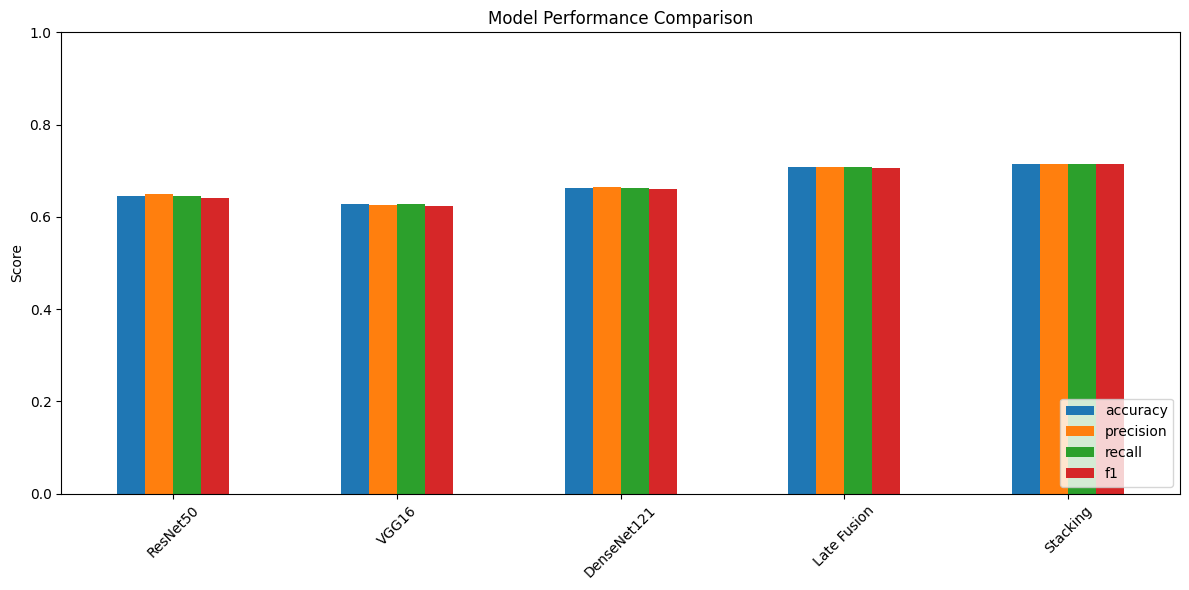

            accuracy precision  recall        f1
ResNet50      0.6455  0.648482  0.6455  0.641878
VGG16         0.6284  0.626149  0.6284  0.622603
DenseNet121   0.6615  0.664526  0.6615  0.659772
Late Fusion   0.7091  0.708798  0.7091    0.7056
Stacking      0.7153  0.714156  0.7153  0.714031


In [ ]:
# Compare all models
def compare_models(metrics_dict):
    """Compare performance metrics of all models"""
    models = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame(index=models, columns=metrics)
    
    for model in models:
        for metric in metrics:
            comparison_df.loc[model, metric] = metrics_dict[model][metric]
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    comparison_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Create a dictionary of all model metrics
all_metrics = {
    'ResNet50': resnet_metrics,
    'VGG16': vgg_metrics,
    'DenseNet121': densenet_metrics,
    'Late Fusion': late_fusion_metrics,
    'Stacking': stacking_metrics
}

# Compare all models
print("Model Performance Comparison:")
comparison_df = compare_models(all_metrics)
print(comparison_df)